In [1]:
import pandas as pd
import xml.etree.ElementTree as ET

# Load XML file
tree = ET.parse("detector_output.xml")  # your SUMO output
root = tree.getroot()

data = []
for interval in root.findall('interval'):
    data.append({
        'begin': float(interval.get('begin')),
        'end': float(interval.get('end')),
        'id': interval.get('id'),
        'flow': float(interval.get('flow')),
        'occupancy': float(interval.get('occupancy')),
        'speed': float(interval.get('speed')),
        'nVeh': int(interval.get('nVehContrib'))
    })

df = pd.DataFrame(data)
df.to_csv("traffic_data.csv", index=False)
print(df.head())


   begin   end     id  flow  occupancy  speed  nVeh
0    0.0  60.0  det_1  60.0       0.64  12.97     1
1    0.0  60.0  det_2  60.0       0.58  14.46     1
2    0.0  60.0  det_3   0.0       0.00  -1.00     0
3    0.0  60.0  det_4   0.0       0.00  -1.00     0
4    0.0  60.0  det_5   0.0       0.00  -1.00     0


In [2]:
def label_congestion(row):
    if row['speed'] < 5 or row['occupancy'] > 0.4:
        return 'High'
    elif row['speed'] < 10 or row['occupancy'] > 0.25:
        return 'Medium'
    else:
        return 'Low'

df['congestion'] = df.apply(label_congestion, axis=1)
print(df[['id', 'speed', 'occupancy', 'congestion']].head())


      id  speed  occupancy congestion
0  det_1  12.97       0.64       High
1  det_2  14.46       0.58       High
2  det_3  -1.00       0.00       High
3  det_4  -1.00       0.00       High
4  det_5  -1.00       0.00       High


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['flow', 'occupancy', 'speed', 'nVeh']]
y = df['congestion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        High       1.00      1.00      1.00       144

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144



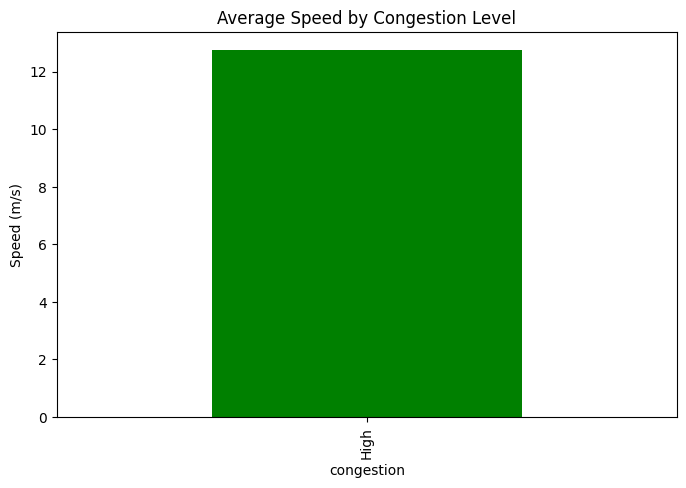

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df.groupby('congestion')['speed'].mean().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Average Speed by Congestion Level')
plt.ylabel('Speed (m/s)')
plt.show()
